<a href="https://colab.research.google.com/github/WeiShengL/Machine-Learning/blob/main/Week5_PCA_(19107650).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing matplotlib and related modules
import matplotlib.pyplot as plt
import matplotlib as mpl

#importing numpy and the time function for measuring training/evaluating time
import numpy as np
import time

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

#importing linear algebra modules
from scipy import linalg

#Set default figure size
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['figure.dpi']=200 # dots per inch
plt.style.use('ggplot') #choosing plot styles

#Useful for debugging problems
print(tf.__version__)

2.7.0


### Import MNIST data and reshaping

In [ ]:
mnist = keras.datasets.mnist   #Uploading the MNIST database

(train_images, train_labels), (test_images, test_labels) = mnist.load_data() #load the data

#reshape the data into pictures that can be used as an input for a CNN
train_images = train_images.reshape((train_images.shape[0], 28,28,1))
test_images = test_images.reshape((test_images.shape[0], 28,28,1))

# Normalize pixel values to be between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

### Creating Model

Using `def` to write a function that creates model for training
<br>
The hyperparameters are chosen to be similar to Week4 MNIST CNN exercise including **convolutional layer**, **Max Pooling** and **Dropout**

In [ ]:
def train_model(train_images, epochs):
    '''
    Function that creates a model, compile it
    then train it with given data(train_images)
    with a given number of epochs
    '''
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1))) # convolutional layer
    model.add(keras.layers.MaxPool2D())                                                      # pool layer
    model.add(keras.layers.Flatten())                                                        # flatten data
    model.add(keras.layers.Dense(128, activation='relu'))                                    # dense layer
    model.add(keras.layers.Dropout(0.3))                                                     # dropout layer
    model.add(keras.layers.Dense(10))                                                        # output layer

    # compiling model with chosen optimizer
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    
    # training model with given dataset
    history = model.fit(train_images, train_labels, epochs=epochs, validation_data=(test_images, test_labels), verbose=0)
    
    return history, model

### Training

A model is created and trained using previously defined function.
<br>
Then it was evaluated against the test images.

In [ ]:
history, model = train_model(train_images, 2)                              # create and train model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)  # evaluating model with test images
print("Test Accuracy = {0:.2f} %".format(test_acc*100))

313/313 [==============================] - 1s 3ms/step - loss: 0.0427 - accuracy: 0.9866
Test Accuracy = 98.66 %


A test accuracy 98.66% of is obtained (>95%)

## Decomposing Train & Test Images
Train and Test images dataset from MNIST is then decompose into PCA components

First by reshaping the pixels of images 28x28 = 784
<br>
The mean of data is shifted to be 0.
<br>
The covariance matrix of data is made by using `np.cov`.
<br>
Then their eigenvalues and respective eigenvectors are obtained using `linalg.eigh`.
<br>
The eigenvalues and eigenvectors need to be flip at the end so that we get the best components first.

In [ ]:
# Reshaping
X_train=np.reshape(train_images,(60000,784))                # reshaping train images
X_test=np.reshape(test_images,(10000,784))                  # reshaping test images
print("X_train.shape:",np.shape(X_train))
print("X_test.shape:",np.shape(X_test))

# Shifting data
mu_train=np.mean(X_train,axis=0)                            # mean of train images
mu_test=np.mean(X_test,axis=0)                              # mean of test images
x_train=X_train-mu_train
x_test=X_test-mu_test

# Covariance matrix
rho_train=np.cov(x_train,rowvar=False)                     # Make the covaraince matrix for train images
rho_test=np.cov(X_test,rowvar=False)                       # Make the covaraince matrix for test images
print("rho_train.shape:",np.shape(rho_train))
print("rho_test.shape:",np.shape(rho_test))

# Get the eigenvalues and vectors
vals_train,vecs_train=linalg.eigh(rho_train)
vals_test,vecs_test=linalg.eigh(rho_test)
#vals is a 1-D array of the eigenvalues in ascending order, vecs is a columnwise array of the normalised
# eigenvectors such that vecs[:,i] is the eigenvector correspondong to vals[i]
print("vecs_train.shape:",np.shape(vecs_train))
print("vals_train.shape:",np.shape(vals_train))
print("vecs_test.shape:",np.shape(vecs_test))
print("vals_test.shape:",np.shape(vals_test))

# Flipping eigenvalues and eigenvectors
vecs_train=np.flip(vecs_train)
vals_train=np.flip(vals_train)
vecs_test=np.flip(vecs_test)
vals_test=np.flip(vals_test)

X_train.shape: (60000, 784)
X_test.shape: (10000, 784)
rho_train.shape: (784, 784)
rho_test.shape: (784, 784)
vecs_train.shape: (784, 784)
vals_train.shape: (784,)
vecs_test.shape: (784, 784)
vals_test.shape: (784,)


## Test accuracy

Using different values of N-best PCA components of test images, the previous trained model is evaluated respectively.

### Create new test images
To create new test images using N-best PCA components, we have to use `np.dot` .
<br>
First, P is obtained by

$$ P = v x$$

where $x$ is the input images
<br>
$v$ is the eigenvectors

Then we can get our output images by

$$Output = P v^{T}$$

The mean of output images is then shifted back again and reshape for input of model.

A graph is then plotted.

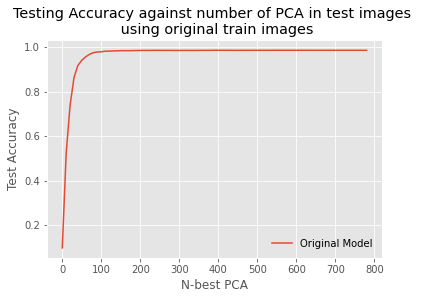

In [ ]:
plt.figure()
P_test=np.dot(x_test,vecs_test)                       # obtaining P for test images
n_PCA_test = range(0, len(vals_test)+1, 10)           # creating range for different number of components used
test_accuracy=[]                                      # empty array for test accuracy output

# Loop for different number of components in test images
for i in n_PCA_test:
        
    newImages_test =(np.dot(P_test[:,0:i],vecs_test.T[0:i,:]))+mu_test      # creating test images with n PCA components
    PCA_test = np.reshape(newImages_test,(10000, 28,28, 1))                 # reshaping the image to be input of the CNN
    test_loss, test_acc = model.evaluate(PCA_test, test_labels, verbose=0)  # evaluating model for the specific test dataset
    test_accuracy.append(test_acc)                                          # appending accuracy value

# Plot
plt.plot(n_PCA_test, test_accuracy, label='Original Model')                                                           
plt.title("Testing Accuracy against number of PCA in test images \n using original train images") # plot title
plt.xlabel("N-best PCA")                                                                          # label x-axes
plt.ylabel("Test Accuracy")                                                                       # label y-axes
plt.legend(loc='best')                                                                            # show legend

## New Models

A function is defined to create a model and trained by only using a given number of N-best PCA components from the training images. This is done by similar steps as before.

Then, function plots out the test accuracy against test images with different number of best PCA components used. 

In [ ]:
P_train=np.dot(x_train,vecs_train)       # P for train images

def model_train_plot(n_PCA_train, epochs):
    newImages_train =(np.dot(P_train[:,0:n_PCA_train],vecs_train.T[0:n_PCA_train,:]))+mu_train #recreating the train images with first 20 PC
    PCA_train = np.reshape(newImages_train,(60000, 28,28, 1)) #reshaping the image to be input of the CNN

    history, new_model = train_model(PCA_train, epochs)  

    new_test_accuracy=[]                                      # empty array for test accuracy output

    # Loop for different number of components in test images
    for i in n_PCA_test:
        
        newImages_test =(np.dot(P_test[:,0:i],vecs_test.T[0:i,:]))+mu_test      # creating test images with n PCA components
        PCA_test = np.reshape(newImages_test,(10000, 28,28, 1))                 # reshaping the image to be input of the CNN
        test_loss, test_acc = new_model.evaluate(PCA_test, test_labels, verbose=0)  # evaluating model for the specific test dataset
        new_test_accuracy.append(test_acc)                                          # appending accuracy value

    # Plot
    plt.plot(n_PCA_test, new_test_accuracy, label="%i-best PCA-Components"%n_PCA_train)                                                            
    plt.title("Testing Accuracy against number of PCA in test images for different model")               # plot title
    plt.xlabel("N-best PCA")                                                                          # label x-axes
    plt.ylabel("Test Accuracy")                                                                       # label y-axes
    plt.legend(loc='best')                                                                            # show legend

    return


## 100-best PCA Component

Using a model trained using train images of 100-best PCA components.

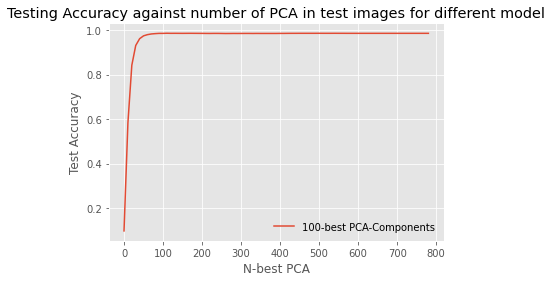

In [ ]:
plt.figure()
model_train_plot(100, 2)

## 20-best PCA Component

Using a model trained using train images of 20-best PCA components.

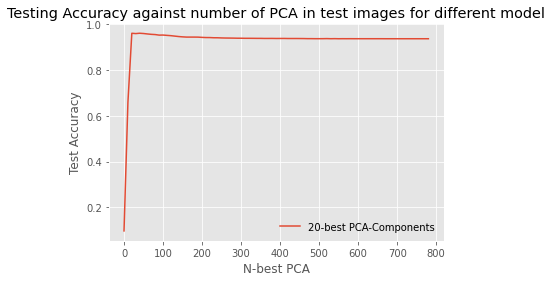

In [ ]:
plt.figure()
model_train_plot(20, 2)

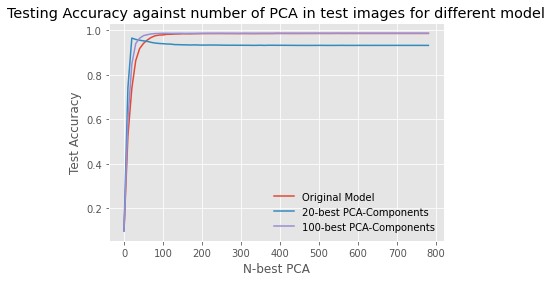

In [ ]:
plt.figure()
plt.plot(n_PCA_test, test_accuracy, label='Original Model')
n_PCA_train = [20, 100]

for i in n_PCA_train:
    model_train_plot(i, 2)

## Discussion

By looking at the graphical comparison, there are many observations to be made

### 20-best PCA components used
It is observed that with 20-best PCA components use the testing accuracy rises very quickly and reaches it's peak at around 10-30 PCA components used in testing images. This is expected as it is trained to recognise simple images. But the accuracy drops off after, implying that this model is not the best in 'real world.

### 100-best PCA components used
On the other hand, with 100-best PCA components use for trained model, the testing accuracy rises quickly too and does not decrease after. The testing accuracy is also very similar to the one obtained by using the original model. This implies that even with only 100-best PCA components used for trianing, it might be sufficient enough to trained a good model.